<a href="https://colab.research.google.com/github/sebasPeimbert/proyecto-final-/blob/main/Dos_Var_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy 
from scipy.integrate import odeint
from scipy import stats 
import seaborn as sns

In [ ]:
# Los tiempos, observaciones y desviaciones estandar de las observaciones
#Datos_Caida_Libre = pd.read_csv("/content/Datos Caida Libre.csv")
#tiempo = np.array(Datos_Caida_Libre['Tiempo (s)'])
#y_obs = np.array(Datos_Caida_Libre[' y (cm)'])
#sigma = np.array(Datos_Caida_Libre['sigmax'])

tiempo =np.array([0.0, 0.017, 0.033, 0.05, 0.067, 0.083, 0.1, 0.117, 0.133, 0.15, 0.167, 0.183, 0.2, 0.217, 0.233, 0.25, 0.267, 0.283, 0.3, 0.317, 0.333, 0.35, 0.367, 0.383, 0.4, 0.417, 0.433, 0.45, 0.467, 0.483, 0.5])
y_obs = np.array([0.0, 0.9, 2.0, 3.5, 5.2, 7.2, 9.4, 12.0, 14.7, 17.7, 21.0, 24.6, 28.4, 32.5, 36.9, 41.5, 46.4, 51.8, 57.2, 62.9, 68.8, 75.2, 81.7, 88.5, 95.6, 102.9, 110.6, 118.5, 126.6, 135.1, 143.8])
sigma = np.array([0.9, 1.1, 1.5, 1.7, 2.0, 2.2, 2.6, 2.7, 3.0, 3.3, 3.6, 3.8, 4.1, 4.4, 4.6, 4.9, 5.4, 5.4, 5.7, 5.9, 6.4, 6.5, 6.8, 7.1, 7.3, 7.7, 7.9, 8.1, 8.5, 8.7, 8.8])

In [ ]:
#Nuestro principal objetivo estimar los valores de g y v.

c = 0.0001 #Nuestra propuesta de la constante de fricción
def CaidaLibre(vx, t, g):
    v, x = vx
    #Sistema de ecuaciones dif
    dv_t = g - c*v**2 #ec1
    dx_t = v   #ec2
    return dv_t, dx_t
#OBS: el signo de dv/dt cambia pues de lo contrario tendriamos posiciones 
#y velocidades negativas

In [ ]:
#Las condiciones iniciales de la EDO
vx0 = [0,0]

#Valores del parametro g
g = 1000 #IMPORTANTE: las unidades deben ser cm/s^2

#La solucion de la ecuación en los tiempos conocidos es:
sol = odeint(CaidaLibre, vx0, tiempo, args = (g,))
V = sol[:,0]
X = sol[:,1]
#La gráfica de la solución es:
fig = plt.figure()
plt.style.use('seaborn-darkgrid')
plt.scatter(x = tiempo, y = X, color ='crimson', label = 'x(t)')
plt.title('Datos simulados')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (cm)')
plt.plot(tiempo, V, color ='coral', label = 'v(t)')
plt.legend()
plt.show()

In [ ]:
#Ahora, la gráfica que nos muestra los datos con sus incertidumbres
fig = plt.figure()
plt.style.use('seaborn-darkgrid')
plt.scatter(x = tiempo, y = y_obs , color ='purple', label = 'Observaciones')
plt.title('Datos observados')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (cm)')
plt.errorbar(x = tiempo, y= y_obs, yerr= 2*sigma, fmt = '.', color = 'purple' )
plt.legend()
plt.show()

In [ ]:
#En la siguiente gráfica se observan los datos observados 
#comparados con los datos simulados
plt.figure()
plt.style.use('seaborn-darkgrid')
plt.scatter(x = tiempo, y = y_obs , color ='purple', label = 'Observaciones')
plt.errorbar(x = tiempo, y= y_obs, yerr= sigma*2, fmt = '.', color = 'purple' )
plt.scatter(x = tiempo, y = X, color ='crimson', label = 'Simulacion')
plt.title('Comparación de datos')
plt.legend(loc='best')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (cm)')
plt.show()


In [ ]:
#La función Forward map
def forwardmap(theta):
    g = theta[0] 
    v = theta[1]
    vx0 = [v,0]
    sol = odeint(CaidaLibre,vx0,tiempo,args=(g,))
    post = sol[:,1]
    return post

In [ ]:
#Se hace el cálculo de la verosimilitud
#Se define la funcion L :

def L(y, theta,sigma=sigma):
    X = forwardmap(theta)
    c_N = 1/(((np.prod(sigma)**2)*2*np.pi)**0.5)
    L = (np.exp(-0.5*np.linalg.norm((X-y)/sigma)**2))*c_N
    return L

#print(L(y_obs, theta=np.array([1000,40])))    

#La funcion del logaritmo de L
def logL(y,theta):
    l = L(y,theta)
    return np.log(l)

In [ ]:
# PROPUESTAS DE g Y v
#theta=[g,v0]
g_min = 800 #el valor minimo de g que se propone
g_max = 1200 #el valormaximo de g que se propone

v_min = 20 #el valor minimo de v que se propone
v_max = 80 #el valor maximo de v que se propone

n = 100 #una matriz de 100x100
Gs = np.linspace(g_min, g_max, n) 
Vs = np.linspace(v_min, v_max, n)
G,V = np.meshgrid(Gs, Vs)
#genera las cordenadas de todos los posibles valores de g 
#y todos los posibles valores de v

In [ ]:
##########################
Ver_List = np.zeros((n,n))
##########################
#Se crea una matriz con los distintos valores de verosimilitud
#con los distintos valores de g y v posibles

for g in range(n):
    for v in range(n):
        theta = np.array([Gs[g],Vs[v]])
        Ver_List[g][v]= L(y=y_obs,theta=theta)

        
#ya que se tiene la matriz de verosimilitud
#lo que sigue, es encontrar los indices
#de g y v que dan el maximo en la verosimilitud
Ver_max = np.max(Ver_List) #Encuentra el valor maximo de la verosimilitud
indmax = np.where(Ver_List == np.max(Ver_List)) #encuentra los indices 
#es un arreglo de dos entradas donde la primera
#pertenece al idice de g y la segunda al indice de v
indmG= indmax[0] #indice donde G tiene max verosimilitud
indmV= indmax[1] #indice donde V tiene max verosimilitud

# Grafica de parametros vs verosimilitud
#se gráfican los valores de verosimilitud encontrados
fig1, axs = plt.subplots(1)
plt.style.use('seaborn-darkgrid')
fig1.suptitle('Parámetros vs Verosimilitud')
axs.contour(G,V,Ver_List, cmap= 'magma')
plt.ylabel('Velocidad (cm/s)')
plt.xlabel('Gravedad (cm/s²)')
plt.show()


In [ ]:
##########################
lver_list = np.zeros((n,n))
##########################
#se crea una lista donde se alacenaran
#el logaritmo de la verosimilitud en distintos puntos


for g in range(n):
  for v in range(n):
    theta = np.array([Gs[g],Vs[v]])
    lver_list[g][v]= logL(y=y_obs,theta=theta)


# Grafica de logaritmo de la verosimilitud
fig1, axs = plt.subplots(1)
plt.style.use('seaborn-darkgrid')
fig1.suptitle('Log(Verosimilitud)')
axs.contour(G,V,lver_list, cmap= 'magma')
plt.scatter(Gs[indmG],Vs[indmV],marker="o", color='crimson', alpha = 0.7, label = 'Máxima verosimilitud')
plt.ylabel('Velocidad (cm/s)')
plt.xlabel('Gravedad (cm/s²)')
plt.legend()
plt.show() 


In [ ]:
#Ahora la gráfica de las marginales
#Calculo de las marginales para los ejes x y y, gravedad y velocidad

hver_G = Ver_List.sum(axis=0)
hver_V = Ver_List.sum(axis=1)

#Figura con las marginales
fig2, (ax1, ax2)= plt.subplots(1, 2,figsize = (10,5))
plt.style.use('seaborn-darkgrid')
fig2.suptitle('Marginales Verosimilitud')

ax1.plot(Gs,hver_G,color='darkred', alpha=0.5) 
ax1.set_title("Gravedad") 
ax1.fill_between(Gs,hver_G, 0,color='darkred', alpha=0.25 )

ax2.plot(Vs,hver_V,color='darkred', alpha=0.5) 
ax2.set_title('Velocidad')
ax2.fill_between(Vs, hver_V, 0,color='darkred', alpha=0.25)
plt.show()


In [ ]:
#MODELO APRIORI
#Se define la función pi apriori de g
#distribución uniforme 
def pi_apG(g):
  if g_min <= g <= g_max:
    return 1/(g_max-g_min)
  else:
    return 0  

#se define la funcion apriori de v
#distribución uniforme 
def pi_apV(v):
  if v_min <= v <= v_max:
    return 1/(v_max-v_min)
  else:
    return 0      

#se define la función pi apriori del problema
def pi_a(theta):
    gr,ve = theta
    pig = pi_apG(gr)
    piv = pi_apV(ve)
    return pig*piv

#logaritmo de pi apriori
def logAp(theta):
    logap = pi_a(theta)
    return np.log(logap)
         

In [ ]:
##########################
apr_list = np.zeros((n,n))
##########################
#se crea una lista donde se alacenaran
#los datos obtenidos de la funcion apriori

for g in range(n):
  for v in range(n):
    theta = np.array([Gs[g],Vs[v]])
    apr_list[g][v]= pi_a(theta)

# Grafica Distribución apriori
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
fig.suptitle('Distribución del modelo apriori')
ax1.scatter(G,V,apr_list, c='firebrick', alpha=0.05, marker='.')
plt.ylabel('Velocidad (cm/s)')
plt.xlabel('Gravedad (cm/s²)')
plt.show() 



In [ ]:
##########################
lg_apr = np.zeros((n,n))
##########################
#se crea una lista donde se alacenaran
#los logaritmos de la funcion apriori

for g in range(n):
  for v in range(n):
    theta = np.array([Gs[g],Vs[v]])
    lg_apr[g][v]= logAp(theta)

In [ ]:
# DISTRIBUCIÓN OBJETIVO
#Pi posteriori
def pi(x): # log(pi(x | y )) = log(L(y | x) + pi_apriori(x))
    log_L = logL(y_obs,x)
    log_apriori = logAp(x)
    return np.exp(log_L + log_apriori)

In [ ]:
##########################
pos = np.zeros((n,n))
##########################
#se crea una lista donde se alacenaran
#los datos obtenidos de la funcion posterior

for g in range(n):
  for v in range(n):
    theta = np.array([Gs[g],Vs[v]])
    pos[g][v]= pi(theta)

MaxPos = np.max(pos) #Encuentra el valor maximo de la posterior
Maxinx = np.where(pos == MaxPos) #encuentra los indices 
#es un arreglo de dos entradas donde la primera
#pertenece al idice de g y la segunda al indice de v
PosG= Maxinx[0] #indice donde G tiene valor maximo en la posterior
PosV= Maxinx[1] #indice donde V tiene valor maximo en la posterior

G_est = Gs[PosG]
V_est = Vs[PosV]

# Grafica de distribución posterior
fig = plt.figure()
plt.style.use('seaborn-darkgrid')
ax1 = fig.add_subplot(111, projection='3d')
fig.suptitle('Distribución Posterior')
ax1.scatter(G,V,pos, c='palevioletred', alpha= 0.25, marker= '.')
plt.ylabel('Velocidad (cm/s)')
plt.xlabel('Gravedad (cm/s²)')
plt.show() 

In [ ]:

#Curvas de nivel de la posterior
fig1, axs = plt.subplots(1)
plt.style.use('seaborn-darkgrid')
fig1.suptitle('Curvas de nivel: Distribución Posterior')
axs.contour(G,V,pos,cmap='magma')
plt.ylabel('Velocidad (cm/s)')
plt.xlabel('Gravedad (cm/s²)')
plt.show() 

In [ ]:
#Logaritmo de la distribucion posterior
logpos= np.log(pos)
fig1, axs = plt.subplots(1)
plt.style.use('seaborn-darkgrid')
fig1.suptitle('Log(Posterior)')
axs.contour(G,V,logpos,cmap= 'magma')
plt.scatter(G_est,V_est,marker="o", color='crimson', alpha = 0.7, label = 'Valor Máximo')
plt.ylabel('Velocidad (cm/s)')
plt.xlabel('Gravedad (cm/s²)')
plt.legend()
plt.show() 

In [ ]:
#MARGIBALES DE LA FUNCIÓN POSTERIOR
#Calculo de las marginales para los ejes x y y, gravedad y velocidad
margG = pos.sum(axis=0)
margV = pos.sum(axis=1)

#Figura con las marginales
fig2, (ax1, ax2) = plt.subplots(1, 2,figsize = (10,5))
plt.style.use('seaborn-darkgrid')
fig2.suptitle('Marginales de la función Posterior')

ax1.plot(Gs,margG,c='palevioletred') 
ax1.set_title("Gravedad") 
ax1.set_xlabel('cm/s²')
ax1.fill_between(Gs,margG, 0,color = 'palevioletred' , alpha= 0.5 )

ax2.plot(Vs,margV,color = 'palevioletred' , alpha= 0.5) 
ax2.set_title('Velocidad')
ax2.set_xlabel('cm/s')
ax2.fill_between(Vs,margV, 0, color = 'palevioletred' , alpha= 0.5)
plt.show()



In [ ]:
#Ya que se conocen los valores estimados, comparamos resultados 

theta=np.array([G_est,V_est])
SimMaxV= forwardmap(theta) #simulacion con maxima verosimilitud
# Graficamos los datos y las soluciones 
plt.figure()
plt.style.use('seaborn-darkgrid')
plt.scatter(x = tiempo, y = y_obs , color ='purple', label = 'Observaciones')
plt.errorbar(x = tiempo, y= y_obs, yerr= sigma*2, fmt = '.', color = 'purple' )
plt.scatter(x = tiempo, y = SimMaxV, color ='crimson', label = 'Simulacion: Máxima verosimilitud')
plt.title('Comparación de datos')
plt.legend(loc='best')
texto1= "g = " + str(round(float(G_est),2)) + " cm/s^2"
texto2= "v = " + str(round(float(V_est),2)) + " cm/s"
plt.text(0,80,texto1,fontsize = 12)
plt.text(0,60,texto2,fontsize = 12)
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (cm)')
plt.show()


In [ ]:
# Distribución de propuestas de pasos
def q(x, y, gamma):
    return np.exp(0.5*np.linalg.norm(x-y)**2/gamma**2)

def paso(x, gamma):
    s = np.random.normal(0, gamma , 2) 
    return x + s     

def alpha(pix,qxy,piy,qyx):
    return min(1, piy*qyx/(pix*qxy))    

def energy(x):
    return np.log(pi(x))       


In [ ]:
#Funcion del algoritmo MH
def MHalg(T,x,gamma):
    chain = np.array(x)                 # cadena para guardar la simulación
    traza = np.array(energy(x))         # cadena para la energia (log pi(x))
    No_acpt = 1
    for k in range(T):
    
     # evaluación de 
        pix = pi(x)
        y = paso(x, gamma)
        piy = pi(y)
        qxy = q(x, y, gamma)
        qyx = q(y, x, gamma)
        # tasa de aceptación
        alfa = alpha(pix, qxy, piy, qyx)
    
        # acepatción
        u = np.random.uniform(0, 1, 1) 
        if u < alfa :
            chain = np.vstack((chain, y))  
            x = y
            No_acpt += 1
        else:
            chain = np.vstack((chain, x))

        traza = np.append(traza, energy(x)) 
            
        aceptance_rate =  No_acpt / T            
    return chain,  traza , aceptance_rate                



In [ ]:
T = 20000                            # tamaño de la cadena de markov
x = np.array([1000,60])              # punto inicial
gamma = 0.5                          # tamaño del paso
alg = MHalg(T,x,gamma)               #Aplicación del algoritmo

Cadena = alg[0]
traza = alg[1]
aceptance_rate = alg[2]

# Figura de con los resultados    
fig2, (ax1, ax2) = plt.subplots(1, 2,figsize = (10,5))
fig2.suptitle('Exploración de la distribución con la MH')
plt.style.use('seaborn-darkgrid')

ax1.contour(G, V, pos, cmap='magma') # distribución objetivo
ax1.scatter(x = Cadena[:,0], y = Cadena[:,1],c = 'indianred', s=2)
ax1.set_title("Resultado de la exploración") 
texto = 'Tasa acept. = ' + str(int(100*aceptance_rate)) + ' %'
ax1.text(800, 25, texto, fontsize = 12)
ax1.set_xlabel("Gravedad cm/s²")
ax1.set_ylabel("Velocidad cm/s")

# traza de la cadena de markov
ax2.plot(traza, c=  'indianred')
ax2.set_title("Energia de la Cadena de Markov") 
plt.show()




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


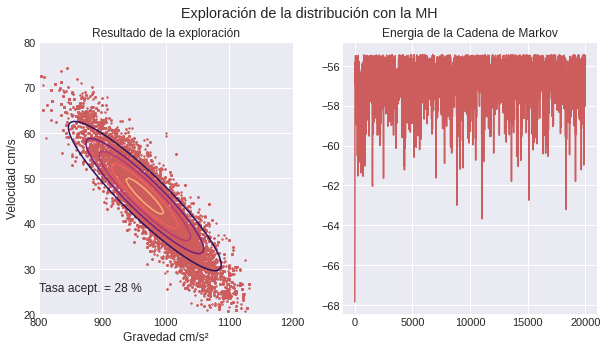

In [ ]:
T = 20000                           # tamaño de la cadena de markov
x = np.array([1000,60])              # punto inicial
gamma = 15                           # tamaño del paso
alg = MHalg(T,x,gamma)

Cadena = alg[0]
traza = alg[1]
aceptance_rate = alg[2]

# Figura de con los resultados    
fig2, (ax1, ax2) = plt.subplots(1, 2,figsize = (10,5))
fig2.suptitle('Exploración de la distribución con la MH')
plt.style.use('seaborn-darkgrid')

ax1.contour(G, V, pos, cmap='magma') # distribución objetivo
ax1.scatter(x = Cadena[:,0], y = Cadena[:,1], c = 'indianred', s=2)
ax1.set_title("Resultado de la exploración") 
texto = 'Tasa acept. = ' + str(int(100*aceptance_rate)) + ' %'
ax1.text(800, 25, texto, fontsize = 12)
ax1.set_xlabel("Gravedad cm/s²")
ax1.set_ylabel("Velocidad cm/s")

# traza de la cadena de markov
ax2.plot(traza,c = 'indianred')
ax2.set_title("Energia de la Cadena de Markov") 
plt.show()

In [ ]:
##########################################
###Calculando el MAP y la media###########
#########################################

#PARA CALCULAR EL MAP
maxTraza = max(traza)
indMaxTra = np.argmax(traza)
MAP = Cadena[indMaxTra]
print(MAP)


#MEDIA DE THETA
G= Cadena[:,0]
V= Cadena[:,1]

medG= np.mean(G)
medV= np.mean(V)
theta_mean = np.array([medG, medV])
print(theta_mean)

[973.81369415  45.0984713 ]
[979.43498732  44.29151369]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 432x288 with 0 Axes>

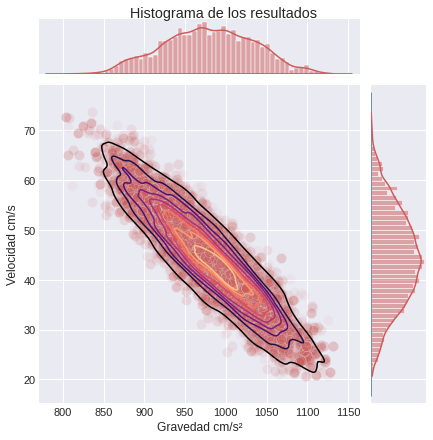

In [ ]:
#########################################
#Histograma de los resultados
#########################################
plt.clf()
plt.style.use('seaborn-darkgrid')
hist=sns.jointplot(Cadena[1500:,0], Cadena[1500:,1], cmap='magma',  kind="kde")
hist.plot_joint(sns.scatterplot,color='indianred',s=100, alpha= 0.05 )
hist.plot_marginals(sns.histplot,color='indianred', kde=True)
hist.set_axis_labels('Gravedad cm/s²', 'Velocidad cm/s')
hist.fig.suptitle('Histograma de los resultados')
plt.subplots_adjust(top=0.95)
plt.show()

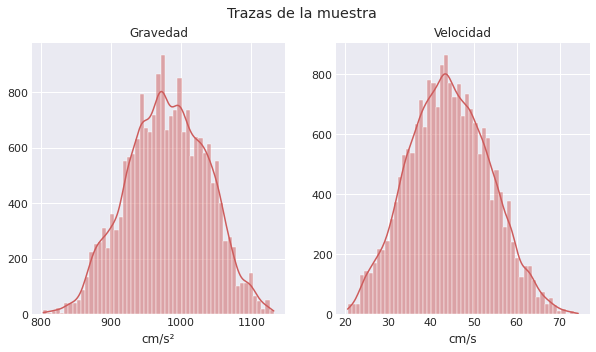

In [ ]:
# La gráfica de las trazasde g y v 
fig, axs = plt.subplots(1, 2,figsize = (10,5))
sns.set(style="darkgrid")
fig.suptitle('Trazas de la muestra')
sns.histplot(Cadena[:,0], kde=True, ax=axs[0],color='indianred', alpha= 0.5)
axs[0].set_xlabel('cm/s²')
axs[0].set_ylabel("")
axs[0].set_title('Gravedad')

sns.histplot(Cadena[:,1], kde=True, ax=axs[1],color='indianred',alpha= 0.5)
axs[1].set_xlabel('cm/s')
axs[1].set_ylabel('')
axs[1].set_title("Velocidad")
plt.show()




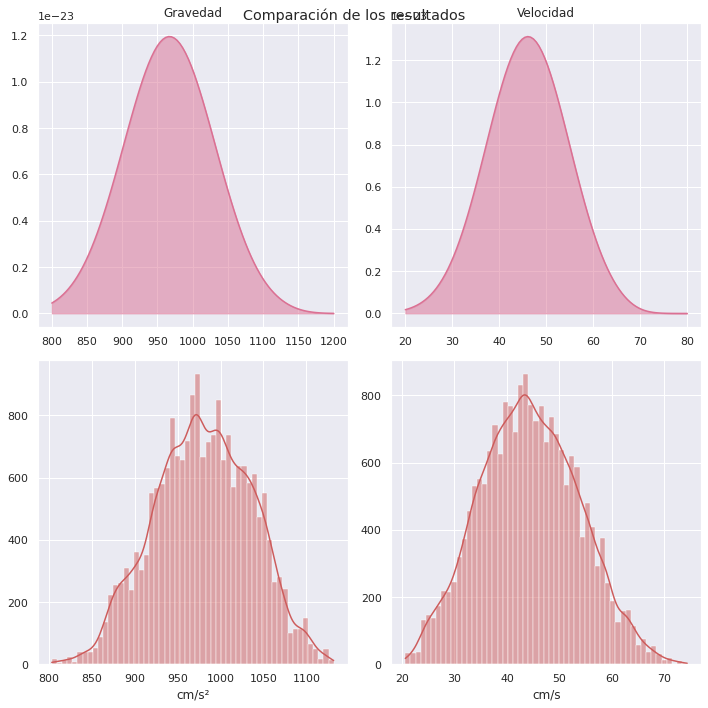

In [ ]:
# Para comparar las trazas con las marginales obtenidas    
fig, axs  = plt.subplots(2, 2,figsize = (10,10))
sns.set(style="darkgrid")
fig.suptitle('Comparación de los resultados')
axs[0, 0].plot(Gs,margG, c='palevioletred') 
axs[0, 0].set_title("Gravedad")
axs[0, 0].fill_between(Gs,margG, 0,color='palevioletred', alpha = 0.5 )
axs[0, 1].plot(Vs, margV,c='palevioletred')
axs[0, 1].fill_between(Vs,margV, 0, color='palevioletred', alpha = 0.5 )
axs[0, 1].set_title("Velocidad")
sns.histplot(Cadena[:,0], kde=True, ax=axs[1,0],color='indianred', alpha= 0.5)
axs[1, 0].set_ylabel('')
axs[1, 0].set_xlabel('cm/s²')
sns.histplot(Cadena[:,1], kde=True, ax=axs[1,1],color='indianred', alpha= 0.5)
axs[1, 1].set_ylabel('')
axs[1, 1].set_xlabel('cm/s')
fig.tight_layout()



In [ ]:
#####PAra concluir, una comparación de simulaciones
# con los valores del MAP obtenidos con los de la media.

SimulacionMAP = forwardmap(MAP)
SimulacionMedia = forwardmap(theta_mean)


fig2, (ax1, ax2) = plt.subplots(1, 2,figsize = (15,5))
plt.style.use('seaborn-darkgrid')
fig2.suptitle('Simulación final')

ax1.scatter(x = tiempo, y = y_obs , color ='purple', label = 'Observaciones')
ax1.errorbar(x = tiempo, y= y_obs, yerr= sigma*2, fmt = '.', color = 'purple' )
ax1.scatter(x = tiempo, y = SimulacionMAP, color ='crimson', label = 'Simulacion: MAP')
ax1.set_title("MAP") 
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel("Posición (cm)")
t1map= "g = " + str(round(float(MAP[0]),2)) + " cm/s²"
t2map= "v = " + str(round(float(MAP[1]),2)) + " cm/s"
ax1.text(0,80,t1map,fontsize = 12)
ax1.text(0,60,t2map,fontsize = 12)
ax1.legend(loc='best')

ax2.scatter(x = tiempo, y = y_obs , color ='purple', label = 'Observaciones')
ax2.errorbar(x = tiempo, y= y_obs, yerr= sigma*2, fmt = '.', color = 'purple' )
ax2.scatter(x = tiempo, y = SimulacionMedia, color ='indianred', label = 'Simulacion: Media')
ax2.set_title('Media')
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel("Posición (cm)")
t1med= "g = " + str(round(float(theta_mean[0]),2)) + " cm/s²"
t2med= "v = " + str(round(float(theta_mean[1]),2)) + " cm/s"
ax2.text(0,80,t1med,fontsize = 12)
ax2.text(0,60,t2med,fontsize = 12)
ax2.legend(loc='best')
plt.show()




